# STOR 543 Code

## Setup

### Deck Creation

In [206]:
import random
from typing import List, Tuple

# Type hints to make code easier to read
Card = int
Hand = Tuple[Card, Card]

def create_deck() -> List[Card]:
    """
    Create and return a fresh 52-card deck represented by integers 0..51.
    """
    return list(range(52))

# create_deck()

**Explanation: Deck Creation**
*   **Purpose**: Initializes the standard 52-card deck.
*   **Representation**: Cards are represented as integers from `0` to `51`.
    *   `0-12`: Clubs (♣)
    *   `13-25`: Diamonds (♦)
    *   `26-38`: Hearts (♥)
    *   `39-51`: Spades (♠)
*   **Why Integers?**: Integer operations (modulo `%` for rank, division `//` for suit) are faster and easier for the computer to process than strings.

### Dealing Cards

In [207]:
def deal_cards(seed: int = None):
    """
    Create a shuffled deck, then deal:
      - 2 cards to Player 1
      - 2 cards to Player 2
      - 5 community cards (flop+turn+river)
    Returns (p1_hand, p2_hand, board, deck)
    where:
      - p1_hand and p2_hand are tuples of 2 Card ints
      - board is a list of 5 Card ints
      - deck is the remaining undealt cards
    """
    # Optional: use a seed for reproducibility
    rng = random.Random(seed)

    deck = create_deck()
    rng.shuffle(deck)

    # Deal 2 cards to each player
    p1_hand = (deck.pop(), deck.pop())  # P1 gets two cards
    p2_hand = (deck.pop(), deck.pop())  # P2 gets two cards

    # Deal 5 community cards (flop 3 + turn 1 + river 1)
    board = [deck.pop() for _ in range(5)]

    return p1_hand, p2_hand, board, deck

# deal_cards(seed=42)

**Explanation:** This function handles the initial setup of a hand. It shuffles the deck and deals two hole cards to each player, along with five community cards (the board). It uses a random seed for reproducibility if provided.

### Card Translator

In [208]:
RANK_CHARS = "23456789TJQKA"
SUIT_CHARS = "♣♦♥♠"  # or "CDHS" if you prefer plain letters

def card_to_rank_suit(card: Card) -> Tuple[str, str]:
    """
    Convert an integer 0..51 into (rank_char, suit_char).
    """
    rank_index = card % 13        # 0..12
    suit_index = card // 13       # 0..3

    rank_char = RANK_CHARS[rank_index]
    suit_char = SUIT_CHARS[suit_index]
    return rank_char, suit_char

def card_to_str(card: Card) -> str:
    """
    Convert an integer 0..51 into a human-readable string, e.g. 'A♠' or '7♥'.
    """
    rank_char, suit_char = card_to_rank_suit(card)
    return f"{rank_char}{suit_char}"

def hand_to_str(hand: Hand) -> str:
    """
    Convert a 2-card hand (tuple of ints) into a string like 'AhKd'.
    """
    c1, c2 = hand
    return f"{card_to_str(c1)} {card_to_str(c2)}"

def board_to_str(board: List[Card]) -> str:
    """
    Convert a list of cards into a string like '7♣ 8♦ 9♥ T♠ J♣'.
    """
    return " ".join(card_to_str(c) for c in board)

**Explanation: Card Translation Utilities**
*   **Purpose**: Converts the internal integer representation of cards into human-readable text.
*   **Functions**:
    *   `card_to_rank_suit(card)`: Extracts the Rank (2-A) and Suit (♣♦♥♠).
    *   `card_to_str(card)`: Returns a string like "A♠" or "7♥".
    *   `hand_to_str(hand)`: Formats a pair of hole cards (e.g., "Ah Kd").
    *   `board_to_str(board)`: Formats the community cards.
*   **Usage**: These are crucial for debugging and visualizing the game state for human players.

#### Example Run

In [209]:
if __name__ == "__main__":
    p1_hand, p2_hand, board, remaining_deck = deal_cards(seed=42)

    print("Player 1 hand:", hand_to_str(p1_hand))
    print("Player 2 hand:", hand_to_str(p2_hand))
    print("Board:        ", board_to_str(board))
    print("Remaining cards in deck:", len(remaining_deck))

Player 1 hand: 3♠ 9♣
Player 2 hand: 3♣ T♠
Board:         6♦ 4♦ 3♦ T♣ 8♣
Remaining cards in deck: 43


**Explanation: Dealing Example**
*   **Action**: Runs a test deal using a fixed random seed (`42`).
*   **Output**: Prints the hands for Player 1 and Player 2, and the Board.
*   **Verification**: This confirms that:
    1.  Cards are being dealt correctly.
    2.  The translation functions work as expected.
    3.  No duplicate cards appear (the deck is properly shuffled and depleted).

### Game Initialization

In [210]:
STARTING_STACK = 100  # chips each player starts with
BLIND = 1             # blind amount paid by the player who acts second

**Explanation: Game Constants**
*   **`STARTING_STACK`**: The number of chips each player begins with (e.g., 100).
*   **`BLIND`**: The forced bet that starts the action. In this simplified Heads-Up game, the player acting second posts the blind.
*   **Significance**: These values define the "economy" of the game. The goal is to win chips from the opponent's stack.

In [211]:
def start_new_hand(seed: int = None):
    """
    Initialise one hand:
      - both players get STARTING_STACK chips
      - pot starts at 0
      - choose who is first / second to act
      - second player posts blind BLIND
      - deal 2 cards to each player and 5 board cards

    Returns a dictionary 'state' containing:
      - 'stacks': [stack_p1, stack_p2]
      - 'pot': current pot size (after blind)
      - 'first_player': index (0 or 1)
      - 'second_player': index (0 or 1)
      - 'p1_hand': (Card, Card)
      - 'p2_hand': (Card, Card)
      - 'board': list of 5 Card
      - 'deck': remaining undealt cards
    """
    # 1) stacks and pot
    stacks = [STARTING_STACK, STARTING_STACK]
    pot = 0

    # 2) decide who is first and second.
    # For now: fix Player 1 (index 0) as first, Player 2 (index 1) as second.
    # Later we will alternate this each hand.
    first_player = 0
    second_player = 1

    # 3) second player posts blind
    stacks[second_player] -= BLIND
    pot += BLIND

    # 4) deal cards
    p1_hand, p2_hand, board, deck = deal_cards(seed=seed)

    # 5) package everything in a state dict
    state = {
        "stacks": stacks,
        "pot": pot,
        "first_player": first_player,
        "second_player": second_player,
        "p1_hand": p1_hand,
        "p2_hand": p2_hand,
        "board": board,
        "deck": deck,
    }
    return state

**Explanation: Initializing a Hand**
*   **Purpose**: Sets up the environment for a single round of poker.
*   **Steps**:
    1.  **Reset Stacks**: Gives both players their starting chips.
    2.  **Post Blinds**: Deducts the blind from the second player and adds it to the pot.
    3.  **Deal Cards**: Distributes hole cards and the board.
    4.  **Create State**: Packages all this information (Stacks, Pot, Hands, Board) into a dictionary.
*   **Return**: A `state` dictionary containing the complete snapshot of the game's beginning.

#### Example Run

In [212]:
if __name__ == "__main__":
    state = start_new_hand(seed=42)

    print("Stacks:       ", state["stacks"])
    print("Pot:          ", state["pot"])
    print("First player: ", state["first_player"])
    print("Second player:", state["second_player"])
    print("P1 hand:      ", hand_to_str(state["p1_hand"]))
    print("P2 hand:      ", hand_to_str(state["p2_hand"]))
    print("Board:        ", board_to_str(state["board"]))
    print("Remaining deck size:", len(state["deck"]))

Stacks:        [100, 99]
Pot:           1
First player:  0
Second player: 1
P1 hand:       3♠ 9♣
P2 hand:       3♣ T♠
Board:         6♦ 4♦ 3♦ T♣ 8♣
Remaining deck size: 43


**Explanation: State Verification**
*   **Action**: Calls `start_new_hand` and prints every element of the resulting state.
*   **Checklist**:
    *   Are stacks correct (100 vs 99)?
    *   Is the pot correct (1)?
    *   Are hands and board populated?
    *   Is the deck size correct (52 - 2 - 2 - 5 = 43)?

### Street

In [213]:
from enum import Enum, auto

class Street(Enum):
    FLOP = auto()
    TURN = auto()
    RIVER = auto()

def visible_board(board: List[Card], street: Street) -> List[Card]:
    """
    Given the full 5-card board and the current street,
    return only the cards that should be visible now.
    """
    if street == Street.FLOP:
        return board[:3]        # first 3 cards
    elif street == Street.TURN:
        return board[:4]        # first 4 cards
    elif street == Street.RIVER:
        return board[:5]        # all 5 cards
    else:
        raise ValueError("Unknown street")
    
if __name__ == "__main__":
    state = start_new_hand(seed=42)
    board = state["board"]

    for street in Street:
        vis_board = visible_board(board, street)
        print(f"{street.name} board: {board_to_str(vis_board)}")

FLOP board: 6♦ 4♦ 3♦
TURN board: 6♦ 4♦ 3♦ T♣
RIVER board: 6♦ 4♦ 3♦ T♣ 8♣


**Explanation: State Verification**
*   **Action**: Calls `start_new_hand` and prints every element of the resulting state.
*   **Checklist**:
    *   Are stacks correct (100 vs 99)?
    *   Is the pot correct (1)?
    *   Are hands and board populated?
    *   Is the deck size correct (52 - 2 - 2 - 5 = 43)?

### Bet Size

In [214]:
BET_SIZE_FLOP = 1
BET_SIZE_TURN = 2
BET_SIZE_RIVER = 4

**Explanation: Betting Structure**
*   **Fixed Limit**: This game uses a "Fixed Limit" betting structure, meaning players cannot bet arbitrary amounts.
*   **Bet Sizes**:
    *   **Flop**: 1 chip.
    *   **Turn**: 2 chips.
    *   **River**: 4 chips.
*   **Impact**: This simplifies the decision space for the AI, as it only needs to decide *whether* to bet, not *how much*.

### Action

In [215]:
class Action(Enum):
    FOLD = auto()
    CHECK_CALL = auto()  # "check" if no bet yet, "call" if facing a bet
    BET = auto()         # only allowed when there is no bet yet

**Explanation: Action Space**
*   **Purpose**: Defines the valid moves a player can make.
*   **Actions**:
    *   `FOLD`: Give up the hand and lose the pot.
    *   `CHECK_CALL`:
        *   **Check**: Pass the action if no bet has been made.
        *   **Call**: Match the opponent's bet to stay in the hand.
    *   `BET`: Place a wager (amount determined by the current street).
*   **Constraint**: The agent must choose exactly one of these actions at each turn.

### GTO Encoding

In [216]:
def is_sb_playable(hand: Hand) -> bool:
    """
    Small Blind (Player 1) Range:
    - Pairs: 22+ (All)
    - Suited: Any suited hand (All)
    - Offsuit:
        - Ax (All)
        - Kx (K5o+)
        - Qx (Q5o+)
        - Jx (J7o+)
        - Tx (T7o+)
        - 9x (97o+)
        - Connectors: 87o, 76o, 65o, 54o
    """
    c1, c2 = hand
    r1, s1 = card_rank(c1), card_suit(c1)
    r2, s2 = card_rank(c2), card_suit(c2)
    
    # Pairs
    if r1 == r2:
        return True
        
    # Suited
    if s1 == s2:
        return True
        
    # Offsuit
    high = max(r1, r2)
    low = min(r1, r2)
    
    # Ax (A=12)
    if high == 12:
        return True
    
    # Kx (K=11) -> K5o+ (5=3)
    if high == 11:
        return low >= 3
        
    # Qx (Q=10) -> Q5o+ (5=3)
    if high == 10:
        return low >= 3
        
    # Jx (J=9) -> J7o+ (7=5)
    if high == 9:
        return low >= 5
        
    # Tx (T=8) -> T7o+ (7=5)
    if high == 8:
        return low >= 5
        
    # 9x (9=7) -> 97o+ (7=5)
    if high == 7:
        return low >= 5
        
    # Connectors: 87o, 76o, 65o, 54o
    # Gap = 1. High in [6, 5, 4, 3] (8, 7, 6, 5)
    if high - low == 1:
        if 3 <= high <= 6:
            return True
            
    return False

def is_bb_playable(hand: Hand) -> bool:
    """
    Big Blind (Player 2) Range:
    - Pairs: 22+ (All)
    - Suited: Any suited hand (All)
    - Offsuit:
        - Ax, Kx, Qx (All)
        - Jx (J4o+)
        - Tx (T5o+)
        - 9x (96o+)
        - 8x (86o+)
        - Connectors/Gappers: 75o+, 64o+, 54o+
    """
    c1, c2 = hand
    r1, s1 = card_rank(c1), card_suit(c1)
    r2, s2 = card_rank(c2), card_suit(c2)
    
    # Pairs
    if r1 == r2:
        return True
        
    # Suited
    if s1 == s2:
        return True
        
    # Offsuit
    high = max(r1, r2)
    low = min(r1, r2)
    
    # Ax, Kx, Qx (12, 11, 10)
    if high >= 10:
        return True
        
    # Jx (9) -> J4o+ (4=2)
    if high == 9:
        return low >= 2
        
    # Tx (8) -> T5o+ (5=3)
    if high == 8:
        return low >= 3
        
    # 9x (7) -> 96o+ (6=4)
    if high == 7:
        return low >= 4
        
    # 8x (6) -> 86o+ (6=4)
    if high == 6:
        return low >= 4
        
    # Connectors/Gappers: 75o+, 64o+, 54o+
    # 75o+ (high=5, low>=3)
    if high == 5:
        return low >= 3
        
    # 64o+ (high=4, low>=2)
    if high == 4:
        return low >= 2
        
    # 54o+ (high=3, low>=2)
    if high == 3:
        return low >= 2
        
    return False

**Explanation: Pre-Flop GTO Ranges**
*   **Concept**: "Game Theory Optimal" (GTO) ranges define which starting hands are statistically profitable to play.
*   **Implementation**:
    *   **`is_sb_playable` (Small Blind)**: Filters Player 1's hands. Includes Pairs, Suited hands, high Offsuit cards (Ax, K5o+), and Connectors (87o+).
    *   **`is_bb_playable` (Big Blind)**: Filters Player 2's hands. Slightly wider range, including more offsuit connectors and gappers.
*   **Why Filter?**: By only allowing "playable" hands to reach the Flop, we simulate a realistic game where players fold junk hands pre-flop. This prevents the AI from wasting time learning how to play 7-2 offsuit.

### Evaluating 5 cards

In [217]:
from itertools import combinations
from collections import Counter

def card_rank(card: Card) -> int:
    return card % 13  # 0..12

def card_suit(card: Card) -> int:
    return card // 13  # 0..3

def _straight_high_card(sorted_unique_ranks_desc):
    """
    Input: unique ranks sorted descending, e.g. [12, 11, 10, 9, 8]
    Returns high-card rank index if there is a 5-card straight, else None.
    Handles the wheel A-2-3-4-5 (returns 3, corresponding to '5').
    """
    ranks = sorted_unique_ranks_desc
    s = set(ranks)

    # Check if wheel (A-2-3-4-5) is even possible
    wheel_possible = {12, 0, 1, 2, 3}.issubset(s)

    # Check normal straights high → low (e.g., KQJT9, QJT98, …)
    for high in range(12, 3, -1):  # 12 down to 4 (4-0 is the lowest non-wheel straight)
        needed = {high - i for i in range(5)}
        if needed.issubset(s):
            return high

    # If none found but wheel is possible, return '5' as high card
    if wheel_possible:
        return 3  # index 3 = '5'
    return None

def evaluate_5(cards: List[Card]):
    """
    Evaluate strength of exactly 5 cards.
    Returns (category, tiebreak_tuple) where higher is better.
    Category:
      8 = Straight Flush
      7 = Four of a Kind
      6 = Full House
      5 = Flush
      4 = Straight
      3 = Three of a Kind
      2 = Two Pair
      1 = One Pair
      0 = High Card
    """
    assert len(cards) == 5

    ranks = [card_rank(c) for c in cards]
    suits = [card_suit(c) for c in cards]

    rank_counts = Counter(ranks)  # e.g. {7:3, 2:2}
    suit_counts = Counter(suits)

    # For some patterns we want ranks sorted by (count, rank)
    # e.g. four of a kind → (rank with count 4, kicker), etc.
    # Sorted descending by count, then rank.
    counts_sorted = sorted(rank_counts.items(), key=lambda x: (x[1], x[0]), reverse=True)

    # Detect flush
    flush_suit = None
    for s, cnt in suit_counts.items():
        if cnt >= 5:
            flush_suit = s
            break
    is_flush = flush_suit is not None

    # Detect straight (ignoring suits)
    unique_ranks_desc = sorted(set(ranks), reverse=True)
    straight_high = _straight_high_card(unique_ranks_desc)
    is_straight = straight_high is not None

    # 8. Straight Flush
    if is_flush:
        flush_cards = [c for c in cards if card_suit(c) == flush_suit]
        flush_ranks = sorted(set(card_rank(c) for c in flush_cards), reverse=True)
        sf_high = _straight_high_card(flush_ranks)
        if sf_high is not None:
            return (8, (sf_high,))

    # 7. Four of a Kind
    if counts_sorted[0][1] == 4:
        quad_rank = counts_sorted[0][0]
        kicker = max(r for r in ranks if r != quad_rank)
        return (7, (quad_rank, kicker))

    # 6. Full House
    if counts_sorted[0][1] == 3 and any(cnt == 2 or cnt == 3 for _, cnt in counts_sorted[1:]):
        trip_rank = counts_sorted[0][0]
        pair_rank = max(r for r, cnt in counts_sorted[1:] if cnt >= 2)
        return (6, (trip_rank, pair_rank))

    # 5. Flush
    if is_flush:
        flush_ranks_all = sorted(
            (card_rank(c) for c in cards if card_suit(c) == flush_suit),
            reverse=True
        )
        top5 = tuple(flush_ranks_all[:5])
        return (5, top5)

    # 4. Straight
    if is_straight:
        return (4, (straight_high,))

    # 3. Three of a Kind
    if counts_sorted[0][1] == 3:
        trip_rank = counts_sorted[0][0]
        kickers = sorted([r for r in ranks if r != trip_rank], reverse=True)[:2]
        return (3, (trip_rank,) + tuple(kickers))

    # 2. Two Pair
    pair_ranks = [r for r, cnt in counts_sorted if cnt == 2]
    if len(pair_ranks) >= 2:
        top2 = sorted(pair_ranks, reverse=True)[:2]
        kicker = max(r for r in ranks if r not in top2)
        return (2, tuple(top2) + (kicker,))

    # 1. One Pair
    if len(pair_ranks) == 1:
        pr = pair_ranks[0]
        kickers = sorted([r for r in ranks if r != pr], reverse=True)[:3]
        return (1, (pr,) + tuple(kickers))

    # 0. High Card
    high5 = tuple(sorted(ranks, reverse=True))
    return (0, high5)

**Explanation: Card Helper Functions**
*   **`card_rank(card)`**: Extracts the rank (0-12) using modulo 13.
*   **`card_suit(card)`**: Extracts the suit (0-3) using integer division by 13.
*   **Usage**: These are fundamental helpers used by the GTO logic and the hand evaluation logic to analyze card properties.

### Evaluating Hand from 5,6,7 Visible Cards

In [218]:
from itertools import combinations

def evaluate_best_from_visible(hole: Hand, visible_board: List[Card]):
    """
    Evaluate the best 5-card hand you can make
    from hole cards + currently visible board.

    Works for:
      - flop (visible_board length = 3, total = 5 cards)
      - turn (length = 4, total = 6 cards)
      - river (length = 5, total = 7 cards)
    """
    cards = list(hole) + list(visible_board)

    if len(cards) == 5:
        # flop: just 2+3, only one 5-card combination
        return evaluate_5(cards)
    else:
        best_value = None
        for combo in combinations(cards, 5):
            value = evaluate_5(list(combo))
            if best_value is None or value > best_value:
                best_value = value
        return best_value

**Explanation: Best 5-Card Combination**
*   **Problem**: In Texas Hold'em, you have 7 cards available (2 hole cards + 5 board cards), but your hand is defined by the *best 5 cards*.
*   **Solution**:
    1.  Combine hole cards and visible board cards.
    2.  Generate all possible 5-card combinations (using `itertools.combinations`).
    3.  Score each combination using `evaluate_5`.
    4.  Return the maximum score found.
*   **Context**: This function adapts to the street. On the Flop, it chooses from 5 cards (2+3). On the River, it chooses from 7 (2+5).

### Comparing Players

In [219]:
def compare_players(p1_hand: Hand, p2_hand: Hand, board: List[Card]):
    """
    Compare Player 1 and Player 2 given their hole cards and the board.
    Returns:
      - 1 if Player 1 wins
      - 2 if Player 2 wins
      - 0 if tie
    """
    v1 = evaluate_best_from_visible(p1_hand, board)
    v2 = evaluate_best_from_visible(p2_hand, board)

    if v1 > v2:
        return 1
    elif v2 > v1:
        return 2
    else:
        return 0

**Explanation: Showdown Logic**
*   **Purpose**: Determines the winner at the end of the game.
*   **Process**:
    1.  Calculate the best hand value for Player 1.
    2.  Calculate the best hand value for Player 2.
    3.  Compare the values.
*   **Outcome**: Returns `1` (P1 wins), `2` (P2 wins), or `0` (Tie/Split Pot).

#### Example Run

In [220]:
if __name__ == "__main__":
    state = start_new_hand(seed=42)
    p1 = state["p1_hand"]
    p2 = state["p2_hand"]
    board = state["board"]

    print("P1:", hand_to_str(p1))
    print("P2:", hand_to_str(p2))
    print("Board:", board_to_str(board))

    winner = compare_players(p1, p2, board)
    print("Winner:", winner)

P1: 3♠ 9♣
P2: 3♣ T♠
Board: 6♦ 4♦ 3♦ T♣ 8♣
Winner: 2


**Explanation: State Verification**
*   **Action**: Calls `start_new_hand` and prints every element of the resulting state.
*   **Checklist**:
    *   Are stacks correct (100 vs 99)?
    *   Is the pot correct (1)?
    *   Are hands and board populated?
    *   Is the deck size correct (52 - 2 - 2 - 5 = 43)?

## Reinforcement Learning Agent

### Poker Environment

In [221]:
class PokerEnv:
    def __init__(self):
        self.STARTING_STACK = 100
        self.BLIND = 1
        self.BET_SIZES = {
            Street.FLOP: 1,
            Street.TURN: 2,
            Street.RIVER: 4
        }
        self.MAX_RAISES = 4 # Cap betting at 4 raises per street
        self.reset()

    def reset(self, seed: int = None):
        """
        Resets the environment for a new hand.
        Implements the 'Pre-Flop Filter': re-deals until hands are 'playable' according to GTO ranges.
        """
        self.rng = random.Random(seed)
        
        # Deal cards
        while True:
            self.p1_hand, self.p2_hand, self.full_board, self.deck = deal_cards(seed=seed if seed else None)
            
            # Check GTO compliance
            # P1 is SB (in this simplified heads-up, usually SB acts first pre-flop, BB acts second)
            # P2 is BB
            if is_sb_playable(self.p1_hand) and is_bb_playable(self.p2_hand):
                break
                
            if seed: break # Don't loop infinitely if seeded

        self.stacks = [self.STARTING_STACK, self.STARTING_STACK]
        self.pot = 0
        
        # P1 is agent, P2 is opponent.
        self.current_player = 0 # 0 for P1, 1 for P2
        
        # Blinds
        self.stacks[0] -= self.BLIND
        self.stacks[1] -= self.BLIND
        self.pot += 2 * self.BLIND

        self.street = Street.FLOP
        self.current_street_bets = {0: 0, 1: 0} # Amount bet by each player on current street
        self.num_raises = 0 # Track number of raises
        self.done = False
        
        return self._get_observation()

    def _get_observation(self):
        """
        Returns the current state observation for the agent (Player 1).
        [My Hand, Visible Board, Pot Size, Stack Sizes, Street, Active Bets]
        """
        vis_board = visible_board(self.full_board, self.street)
        return {
            "my_hand": self.p1_hand,
            "board": vis_board,
            "pot": self.pot,
            "stacks": self.stacks,
            "street": self.street,
            "active_bets": self.current_street_bets
        }

    def get_valid_actions(self):
        """
        Returns a list of valid actions for the current player.
        Enforces the betting cap (MAX_RAISES).
        """
        valid_actions = [Action.FOLD, Action.CHECK_CALL]
        if self.num_raises < self.MAX_RAISES:
            valid_actions.append(Action.BET)
        return valid_actions

    def step(self, action: Action):
        """
        Executes an action for the current player.
        Returns (observation, reward, done, info)
        """
        if self.done:
            raise ValueError("Game is over")

        opponent = 1 - self.current_player
        reward = 0
        
        # Enforce Betting Cap (Auto-correct if agent tries to bet when capped)
        if action == Action.BET and self.num_raises >= self.MAX_RAISES:
            action = Action.CHECK_CALL 
        
        if action == Action.FOLD:
            self.done = True
            if self.current_player == 0: # P1 folded
                reward = - (self.STARTING_STACK - self.stacks[0]) # Lost whatever was put in
            else: # P2 folded, P1 wins
                reward = (self.pot - (self.STARTING_STACK - self.stacks[0])) # Profit = Pot - Cost
            
            self.stacks[opponent] += self.pot
            return self._get_observation(), reward, True, {"winner": opponent}

        elif action == Action.CHECK_CALL:
            amount_to_call = self.current_street_bets[opponent] - self.current_street_bets[self.current_player]
            
            if amount_to_call > 0: # Call
                self.stacks[self.current_player] -= amount_to_call
                self.pot += amount_to_call
                self.current_street_bets[self.current_player] += amount_to_call
                self._advance_street()
            else: # Check
                if self.current_player == 1: # P2 checks after P1 checked
                    self._advance_street()
                else:
                    self.current_player = opponent

        elif action == Action.BET:
            bet_amount = self.BET_SIZES[self.street]
            to_call = self.current_street_bets[opponent] - self.current_street_bets[self.current_player]
            total_wager = to_call + bet_amount
            
            self.stacks[self.current_player] -= total_wager
            self.pot += total_wager
            self.current_street_bets[self.current_player] += total_wager
            self.num_raises += 1 # Increment raise count
            
            self.current_player = opponent

        if self.done:
            return self._get_observation(), reward, True, {}

        return self._get_observation(), 0, False, {}

    def _advance_street(self):
        self.current_street_bets = {0: 0, 1: 0}
        self.num_raises = 0 # Reset raise count
        self.current_player = 0
        
        if self.street == Street.FLOP:
            self.street = Street.TURN
        elif self.street == Street.TURN:
            self.street = Street.RIVER
        elif self.street == Street.RIVER:
            self._showdown()
            return

    def _showdown(self):
        self.done = True
        winner = compare_players(self.p1_hand, self.p2_hand, self.full_board)
        
        reward = 0
        if winner == 1: # P1 wins
            reward = self.pot - (self.STARTING_STACK - self.stacks[0])
            self.stacks[0] += self.pot
        elif winner == 2: # P2 wins
            reward = - (self.STARTING_STACK - self.stacks[0])
            self.stacks[1] += self.pot
        else: # Tie
            split = self.pot / 2
            self.stacks[0] += split
            self.stacks[1] += split
            reward = split - (self.STARTING_STACK - self.stacks[0])

        self.showdown_reward = reward

    def step_wrapper(self, action):
        obs, reward, done, info = self.step(action)
        if done and hasattr(self, 'showdown_reward'):
            reward = self.showdown_reward
            del self.showdown_reward
        return obs, reward, done, info

**Explanation: Poker Environment (Updated)**\n*   **`get_valid_actions`**: Returns legal moves. If `num_raises >= MAX_RAISES`, `BET` is removed from the list.\n*   **`step`**: Auto-corrects `BET` to `CHECK_CALL` if capped (safeguard), but `get_valid_actions` prevents this from being needed often.

### Q-Learning Agent

In [222]:
import random
import pickle
from collections import defaultdict

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.q_table = defaultdict(float) # Maps (state, action) -> value
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = [Action.FOLD, Action.CHECK_CALL, Action.BET]

    def get_action(self, state, valid_actions=None):
        if valid_actions is None:
            valid_actions = self.actions

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        best_value = -float('inf')
        best_action = random.choice(valid_actions)
        
        for action in valid_actions:
            val = self.q_table[(state, action)]
            if val > best_value:
                best_value = val
                best_action = action
        
        return best_action

    def update(self, state, action, reward, next_state, done):
        current_q = self.q_table[(state, action)]
        
        if done:
            max_next_q = 0
        else:
            max_next_q = max([self.q_table[(next_state, a)] for a in self.actions])
            
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(state, action)] = new_q

    def discretize_state(self, observation):
        """
        State: (Hand Strength Bucket, Board Texture, Street, Facing Bet?)
        """
        my_hand = observation['my_hand']
        board = observation['board']
        street = observation['street']
        active_bets = observation['active_bets'] # Dictionary {0: bet_amt, 1: bet_amt}
        
        # 1. Hand Strength
        strength_val = evaluate_best_from_visible(my_hand, board)
        hand_category = strength_val[0] # 0=High Card ... 8=Straight Flush
        
        # 2. Board Texture
        suits = [card_suit(c) for c in board]
        ranks = sorted([card_rank(c) for c in board])
        is_monotone = any(count >= 3 for count in [suits.count(s) for s in range(4)])
        is_paired = len(set(ranks)) < len(ranks)
        texture = (is_monotone, is_paired) # Simplified texture tuple
        
        # 3. Betting Context (CRITICAL FIX)
        # Assuming Agent is Player 0. 
        # If Opponent (1) bet more than Agent (0), we are facing a bet.
        my_amt = active_bets[0]
        opp_amt = active_bets[1]
        facing_bet = opp_amt > my_amt
        
        return (hand_category, texture, street, facing_bet)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = defaultdict(float, pickle.load(f))

**Explanation: Q-Learning Agent (Updated)**
*   **State Representation**: Now includes `facing_bet` (Boolean) to detect if the opponent has raised. Also simplifies board texture.
*   **`discretize_state`**: Converts `(Hand, Board, Street, Bets)` -> `(Category, Texture, Street, FacingBet)`.
*   **Significance**: This allows the agent to learn different strategies for when it is being aggressed vs. when it is checking down.

### Training Loop

In [223]:
class RandomOpponent:
    """
    An opponent that selects a random valid action.
    """
    def get_action(self, state: tuple, valid_actions: list[Action], hand: list, board: list) -> Action:
        """Selects a random action from the list of valid actions."""
        return random.choice(valid_actions)

class ConservativeOpponent:
    """
    An opponent that plays tight. 
    It only bets or calls if it has a Pair (Category >= 1) or better.
    Otherwise, it folds or checks if possible.
    """
    def get_action(self, state: tuple, valid_actions: list[Action], hand: list, board: list) -> Action:
        """Determines action based on hand strength."""
        # Calculate actual hand strength
        strength_val = evaluate_best_from_visible(hand, board)
        hand_category = strength_val[0] 
        
        # If hand is strong (Pair or better)
        if hand_category >= 1:
            if Action.BET in valid_actions: return Action.BET
            return Action.CHECK_CALL
            
        # If hand is weak
        if Action.CHECK_CALL in valid_actions:
            # Check if we can check (no cost)
            return Action.CHECK_CALL 
        return Action.FOLD

class AggressiveOpponent:
    """
    An opponent that plays aggressively.
    It has a 30% chance to bluff (bet) regardless of hand strength.
    """
    def get_action(self, state: tuple, valid_actions: list[Action], hand: list, board: list) -> Action:
        """Selects an action, occasionally bluffing."""
        # 30% chance to bet regardless of hand (Bluff)
        if random.random() < 0.30 and Action.BET in valid_actions:
            return Action.BET
        return random.choice(valid_actions)

**Explanation: Patterned Opponents**
*   **`RandomOpponent`**: Baseline.
*   **`ConservativeOpponent`**: Plays tight. Only bets/calls with a Pair or better. Folds weak hands.
*   **`AggressiveOpponent`**: Bluffs 30% of the time.
*   **Purpose**: Testing against these archetypes allows us to verify if the agent can learn *exploitative* strategies (e.g., bluffing the conservative player, calling down the aggressive one).

### Training and Visualization

In [224]:
def train_and_plot(episodes: int = 10000, opponent_cls=RandomOpponent) -> QLearningAgent:
    """
    Trains the Q-Learning agent against a specified opponent and plots the results.

    Args:
        episodes (int): Number of training episodes.
        opponent_cls (class): The class of the opponent to train against.

    Returns:
        QLearningAgent: The trained agent.
    """
    env = PokerEnv()
    agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=0.1)
    opponent = opponent_cls()
    
    # Metrics storage
    win_rates = []
    avg_rewards = []
    episode_nums = []
    
    wins = 0
    total_reward = 0
    log_interval = 500
    
    print(f"Starting training for {episodes} episodes against {opponent_cls.__name__}...")
    
    for episode in range(episodes):
        obs = env.reset()
        state = agent.discretize_state(obs)
        done = False
        
        last_p1_state = None
        last_p1_action = None
        
        while not done:
            if env.current_player == 0: # Agent (P1)
                # Pass valid actions to agent
                valid_actions = env.get_valid_actions()
                action = agent.get_action(state, valid_actions)
                
                next_obs, reward, done, info = env.step_wrapper(action)
                
                if done:
                    agent.update(state, action, reward, None, True)
                    total_reward += reward
                    if reward > 0: wins += 1
                else:
                    last_p1_state = state
                    last_p1_action = action
                    state = agent.discretize_state(next_obs)
            
            else: # Opponent (P2)
                # Opponent needs to see their hand and board
                vis_board = visible_board(env.full_board, env.street)
                # Pass valid actions to opponent (Masking)
                valid_actions = env.get_valid_actions()
                opp_action = opponent.get_action(None, valid_actions, env.p2_hand, vis_board)
                
                next_obs, reward, done, info = env.step_wrapper(opp_action)
                
                if done:
                    if last_p1_state is not None:
                        agent.update(last_p1_state, last_p1_action, reward, None, True)
                    total_reward += reward
                    if reward > 0: wins += 1
                else:
                    current_state_for_p1 = agent.discretize_state(next_obs)
                    if last_p1_state is not None:
                        agent.update(last_p1_state, last_p1_action, 0, current_state_for_p1, False)
                    state = current_state_for_p1

        if (episode + 1) % log_interval == 0:
            avg_reward = total_reward / log_interval
            win_rate = wins / log_interval
            
            win_rates.append(win_rate)
            avg_rewards.append(avg_reward)
            episode_nums.append(episode + 1)
            
            wins = 0
            total_reward = 0
            agent.epsilon = max(0.01, agent.epsilon * 0.99)
            
    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_nums, win_rates, label='Win Rate')
    plt.xlabel('Episodes')
    plt.ylabel('Win Rate')
    plt.title(f'Win Rate vs {opponent_cls.__name__}')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(episode_nums, avg_rewards, label='Avg Reward', color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Average Reward over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return agent

**Explanation: Training Loop (Updated)**\n*   **Action Masking**: Now calls `env.get_valid_actions()` and passes the result to both the Agent and the Opponent. This ensures neither tries to Bet when the betting is capped.

Starting training for 10000 episodes against ConservativeOpponent...


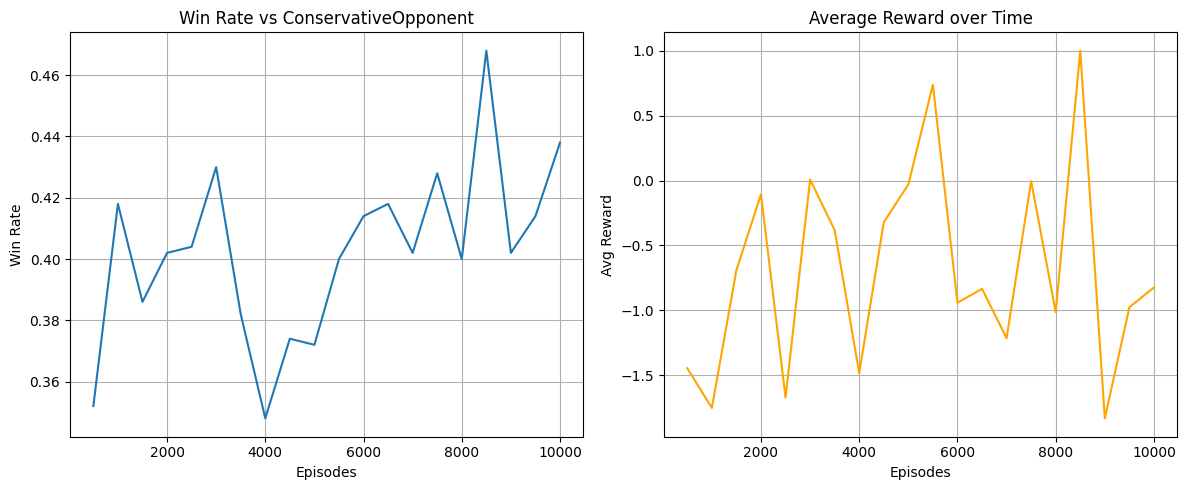

In [225]:
# Train the agent against a Conservative Opponent to learn exploitation
trained_agent = train_and_plot(episodes=10000, opponent_cls=ConservativeOpponent)

**Explanation:** Executing this cell starts the training process. You will see the progress logs and, upon completion, graphs showing the agent's win rate and reward trends.

### Validation Run (No Exploration)

In [226]:
def validate(agent: QLearningAgent, episodes: int = 1000, opponent_cls=RandomOpponent):
    """
    Validates the agent's performance against an opponent without exploration.

    Args:
        agent (QLearningAgent): The trained agent.
        episodes (int): Number of validation episodes.
        opponent_cls (class): The class of the opponent to validate against.
    """
    env = PokerEnv()
    opponent = opponent_cls()
    
    wins = 0
    total_reward = 0
    
    # Turn off exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    print(f"Validating for {episodes} episodes against {opponent_cls.__name__}...")
    
    for _ in range(episodes):
        obs = env.reset()
        state = agent.discretize_state(obs)
        done = False
        
        while not done:
            if env.current_player == 0: # Agent
                valid_actions = env.get_valid_actions()
                action = agent.get_action(state, valid_actions)
                next_obs, reward, done, info = env.step_wrapper(action)
                if not done:
                    state = agent.discretize_state(next_obs)
                else:
                    total_reward += reward
                    if reward > 0: wins += 1
            else: # Opponent
                vis_board = visible_board(env.full_board, env.street)
                valid_actions = env.get_valid_actions()
                opp_action = opponent.get_action(None, valid_actions, env.p2_hand, vis_board)
                
                next_obs, reward, done, info = env.step_wrapper(opp_action)
                if done:
                    total_reward += reward
                    if reward > 0: wins += 1
                else:
                    state = agent.discretize_state(next_obs)
    
    agent.epsilon = original_epsilon
    
    print(f"Validation Results:")
    print(f"Win Rate: {wins/episodes:.2%}")
    print(f"Avg Reward: {total_reward/episodes:.2f}")

validate(trained_agent, opponent_cls=ConservativeOpponent)

Validating for 1000 episodes against ConservativeOpponent...
Validation Results:
Win Rate: 47.60%
Avg Reward: -0.53


**Explanation: Validation (Updated)** 
*   **Opponent**: Validates against the specific opponent class used for training (or another if specified).
*   **Metrics**: Prints Win Rate and Average Reward.

# ==========================================
# PART 3: EXPLOITATION EXPERIMENTS
# ==========================================

This section runs a suite of experiments to demonstrate how the agent adapts to different opponent types.
1.  **Experiment 1**: Train against a **Conservative** player, then validate against both Conservative (expected high win rate) and Aggressive (expected lower win rate/different strategy).
2.  **Experiment 2**: Train against an **Aggressive** player, then validate against both Aggressive and Conservative players.

### Experiment 1: Exploiting the CONSERVATIVE Player
We train the agent against a Conservative opponent. We expect it to learn to bluff and steal pots.

In [ ]:
# 1. Train Agent A vs Conservative
agent_vs_conservative = train_and_plot(episodes=5000, opponent_cls=ConservativeOpponent)

# 2. Validate Agent A vs Conservative (Should Win/Bluff)
print("\n[Result] Agent A vs Conservative (Training Opponent):")
validate(agent_vs_conservative, episodes=500, opponent_cls=ConservativeOpponent)

# 3. Cross-Validation: Agent A vs Aggressive (Should Struggle)
print("\n[Cross-Test] Agent A vs Aggressive (Unseen Opponent):")
validate(agent_vs_conservative, episodes=500, opponent_cls=AggressiveOpponent)

### Experiment 2: Exploiting the AGGRESSIVE Player
We train the agent against an Aggressive opponent. We expect it to learn to call down bluffs and value bet thinly.

In [ ]:
# 1. Train Agent B vs Aggressive
agent_vs_aggressive = train_and_plot(episodes=5000, opponent_cls=AggressiveOpponent)

# 2. Validate Agent B vs Aggressive (Should Call/Trap)
print("\n[Result] Agent B vs Aggressive (Training Opponent):")
validate(agent_vs_aggressive, episodes=500, opponent_cls=AggressiveOpponent)

# 3. Cross-Validation: Agent B vs Conservative (Should Struggle)
print("\n[Cross-Test] Agent B vs Conservative (Unseen Opponent):")
validate(agent_vs_aggressive, episodes=500, opponent_cls=ConservativeOpponent)